# SAN Projekt

In the following notebook, I'm going to analyse a dataset from sociopatterns.org, a platform for "interdisciplinary research collaboration formed in 2008 that adopts a data-driven methodology to study social dynamics and human activity."[^1] Recently, they have visualized "sixty-nine days of face-to-face contact activity among more than 30'000 persons based on data collection during the INFECTIOUS: STAY AWAY exhibiton in the Science Gallery in Dublin, Ireland."[^1]
Sociopatterns.org works together with international scientists and has published ultiple peer reviewed papers. 

The data set I am going to look at studies "the contacts and friendship relations between students in a high school in Marseilles, France, in December 2013, as measured through several techniques."[^2] There are multiple data sets for the same study: 


The first data set looks at interactions between students and how many interactions were active in a period of 20seconds. This period is given by the time variable and the true time interval is: [time variable - 20seconds, time variable]. Data was acquired using the SocioPatterns infrastructure. In the research paper published based on this data it is explained that they used sensors to check for face-to-face proximity between students.[^3] Those sensors were wearable. There was a 86.3% participation rate over all classes. More here: https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0136497.

The second data set is a directed network of contacts between students as reported in contact diaries. In the study they asked students to fill in paper contact diaries at one specific day (05.12.2013, which is also in the sensor data set). The variable are two student IDs which can also be mapped with the student IDs from the other data sets. The important variable here is the reported time from "at most 5 mins" or time variable "w" = 1 to "more than 1h" or time variable "w" = 4.

The third data set is a directed network of reported friendships, similar to the reported contact in data set 2.

The last data set is a list of pairs of student for whom a facebook friendship is known.

There is a metadata file which joins student ID, their class ID and their gender.

By looking through the data sets, I assume each student has only one class ID. There is also an "unknown" gender. 
The data set is also space seperated.

In the research paperit is stated that "most short contacts are not reported in diaries while long contacts have a large reporting probability". Researchers also state that "the durations of contacts tend to be overestimated in the diaries" and that "all long contacts do correspong to a reported friendship". Also that "online links [connections] that are not also reported in the friendship survey correspong to short face-to-face contacts. 

[^1]http://www.sociopatterns.org

[^2]http://www.sociopatterns.org/datasets/high-school-contact-and-friendship-networks/

[^3]https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0136497 

In [37]:
import community
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.animation
import numpy as np
import random
import seaborn as sns
import pandas as pd

import plotly.graph_objects as go
import plotly.express as px
from plotly.offline import iplot
import plotly.io as pio
import math

import utils.qap

In [15]:
plt.rcParams["figure.figsize"] = (20,10)

contact_diaries = pd.read_csv("Contact-diaries.csv", header=None, delim_whitespace=True)
timed_contacts = pd.read_csv("High-School-data.csv", header=None, delim_whitespace=True)
friendships = pd.read_csv("reported-friendship.csv", header=None, delim_whitespace=True)
facebook_pairs = pd.read_csv("facebook-pairs.csv", header=None, delim_whitespace=True)
metadata = pd.read_csv("metadata_2013.txt", header=None, sep='\t')

contact_diaries = contact_diaries.rename(columns={0: 'StudentID', 1: 'ReportedStudentID', 2: 'w'})
timed_contacts = timed_contacts.rename(columns={0: 'Time', 1: 'Student1', 2: 'Student2', 3: 'Student1Class', 4: 'Student2Class'})
friendships = friendships.rename(columns={0: 'StudentID', 1: 'ReportedStudentID'})
facebook_pairs = facebook_pairs.rename(columns={0: 'StudentID', 1: 'ReportedStudentID', 2: 'is_friend'})
metadata = metadata.rename(columns = {0: 'StudentID', 1: 'ClassID', 2: 'Gender'})

print("contact diaries: ", contact_diaries.columns)
print("timed contacts: ", timed_contacts.columns)
print("friendships: ", friendships.columns)
print("facebook pairs: ", facebook_pairs.columns)
print("meta data: ", metadata.columns)

contact diaries:  Index(['StudentID', 'ReportedStudentID', 'w'], dtype='object')
timed contacts:  Index(['Time', 'Student1', 'Student2', 'Student1Class', 'Student2Class'], dtype='object')
friendships:  Index(['StudentID', 'ReportedStudentID'], dtype='object')
facebook pairs:  Index(['StudentID', 'ReportedStudentID', 'is_friend'], dtype='object')
meta data:  Index(['StudentID', 'ClassID', 'Gender'], dtype='object')


In "timed contacts" where sensor data is stored, there are no duplicate values for the same pair of students. If student 454 had contact with 640 there is only one entry with either 454 -> 640 or 640 -> 454. This contact is not directional.

The data could be merged or joined together. For example, contact diaries can be merged with the meta data file and then all students can get gender and class attributes. The contact diaries and the timed contacts dataframes can also be merged or compared as it was done in the research paper. We can also check if reported friendships match facebook friendships.

### IDEAS:

How to predict new contacts? (Link prediciton using SAN formulas and also neural network?) We have a lot of time data. Data over a set period of time can be used to predict the next period. There is theoretically enough train data for this. Attributes that can help link prediciton are gender and class and also the reported friendships or unreported facebook friendship. Unfortunately friendship data is scarce.

### Clarification based on the paper:

Researchers calculated multiple metrics. They defined "density of links between classes X and Y" as Exy normalized by a factor of (n<sub>x</sub> * n<suby></sub> if X = Y and n<sub>x</sub>(n<sub>x</sub> - 1)/2 if X = Y, where nx is the number of students in class X. They also defined the total time spent in contact between classes. Normalization gives the average time spent by a student X with student of class Y. They did this with adjacency matrices which is a way to quickly calculate these metrics. (Comment: Can these matrices be used for a neural net?)

For the analysis, they first took a look at the fact that for the same pair of students one student might have reported w contact time while the other student in that pair might have reported x =/= w contact time. To compare with the sensor data they took the adjacency matrix of the reported contact diaries and symmetrized it. If w<sub>ij</sub> =/ w<sub>ji</sub>, they took the higher w value out of the two.

In the paper they reported that number of contacts fluctuates strongly throughout the day (shown in time series plot below). The daily contact matrices are very similar to each other though with cosine similarities ranging from 92.7% to 98%. This means the mixing patterns are robust. If i want to compare some additional metrics, adjacency matrices are the basis of these calculations. 

### Merge contact diaries and metadata:

In [16]:
contact_diaries = contact_diaries.merge(metadata, left_on='StudentID', right_on='StudentID')
print("contact diaries: ", contact_diaries.columns)

contact diaries:  Index(['StudentID', 'ReportedStudentID', 'w', 'ClassID', 'Gender'], dtype='object')


Joining node attributes via dataframe.merge function is really easy. Now all the attributes are already set.

In [17]:
print("contact diaries isnull count: ", contact_diaries.isnull().any().sum())
print("contact diaries isna count: ", contact_diaries.isna().any().sum())
print("timed contacts isnull count: ",timed_contacts.isnull().any().sum())
print("timed contacts isna count: ", timed_contacts.isna().any().sum())
print("friendships isnull count: ", friendships.isnull().any().sum())
print("friendships isna count: ", friendships.isna().any().sum())
print("facebook pairs isnull count: ", facebook_pairs.isnull().any().sum())
print("facebook pairsisna count: ", facebook_pairs.isna().any().sum())

contact diaries isnull count:  0
contact diaries isna count:  0
timed contacts isnull count:  0
timed contacts isna count:  0
friendships isnull count:  0
friendships isna count:  0
facebook pairs isnull count:  0
facebook pairsisna count:  0


There are no missing values

In [53]:
print("contact diaries duplicates?: ", contact_diaries.duplicated().any())
print("timed contacts duplicates?: ",timed_contacts.duplicated().any())
print("friendships duplicates?: ", friendships.duplicated().any())
print("facebook pairs duplicates?: ", facebook_pairs.duplicated().any())

contact diaries duplicates?:  False
timed contacts duplicates?:  False
friendships duplicates?:  False
facebook pairs duplicates?:  False


The dataset is clean. There are no missing values, no duplicates. Loading into networkx also worked first try.

## Distributions

4    219
3    101
1     93
2     89
Name: w, dtype: int64


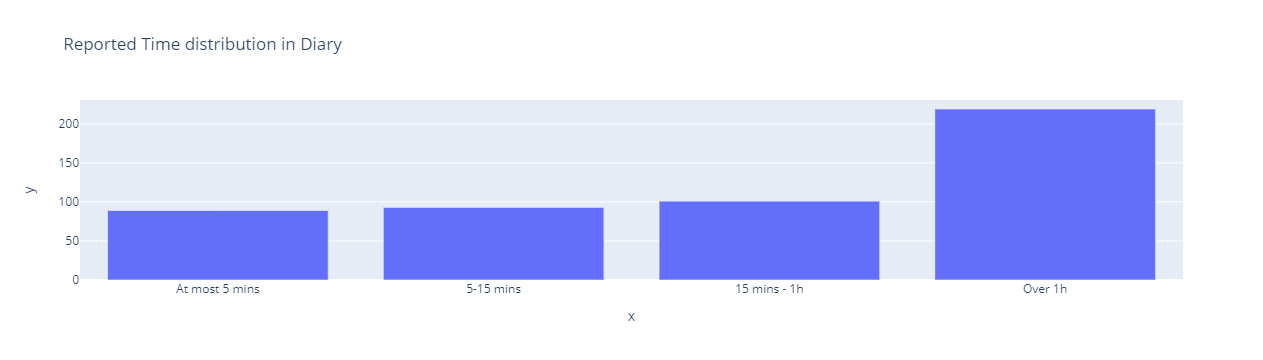

In [54]:
contact_diaries = contact_diaries.sort_values(by=["w"], ascending=False)

counts = contact_diaries.w.value_counts()
print(counts)

fig = px.bar(x=contact_diaries.w.unique(), y=counts, title="Reported Time distribution in Diary")

fig.update_layout(
                xaxis = dict(        
                    tickmode = 'array',
                    tickvals = [1, 2, 3, 4],
                    ticktext = ['At most 5 mins', '5-15 mins', '15 mins - 1h', 'Over 1h']
                )
                )

fig.show()

The reported time follows a right skewed distribution where most students reported contacts of over 1h.

From the paper the directionality clarified:

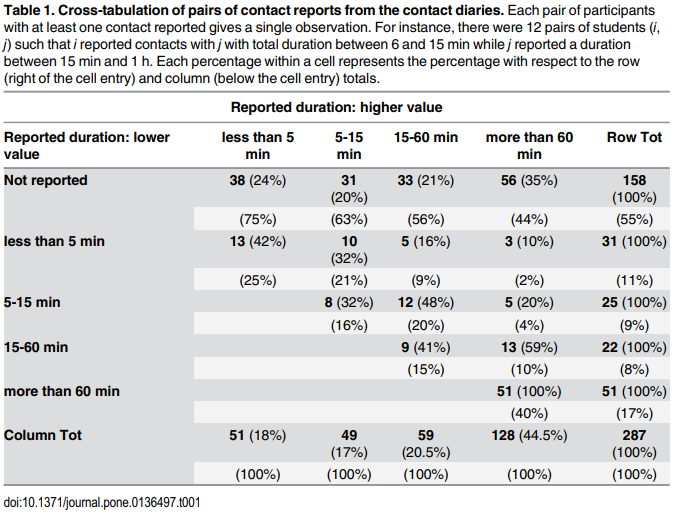

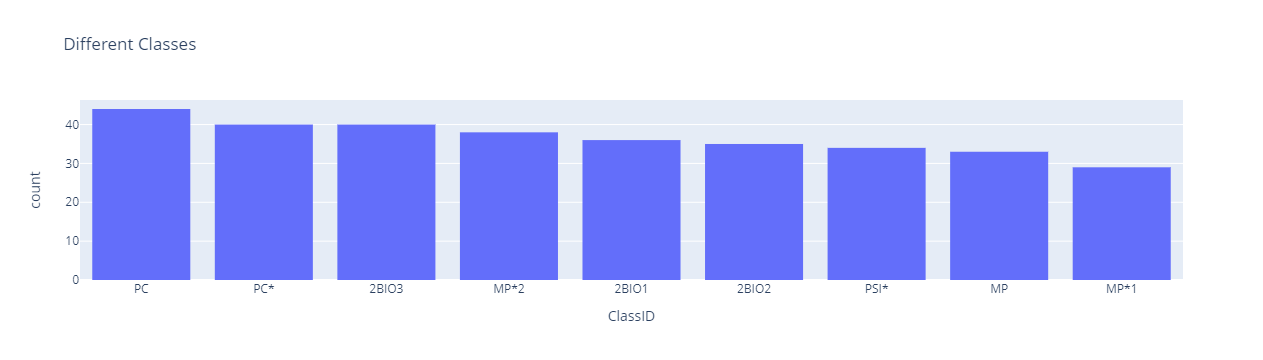

In [55]:
fig = px.histogram(metadata, x="ClassID", title="Different Classes").update_xaxes(categoryorder="total descending")

fig.show()

The class distribution is more or less evenly distributed. In total there are 9 classes. The PC classes are 2 physics and chemistry classes. MP classes focus on mathematics and physics. PSI classes focus on engineering studies and BIO stands for biology classes.

# There are less classes reported in other dataframes CHECK

In [56]:
print("Student Count: ", metadata.StudentID.count())
print("Unique Students reporting for diary: ", len(contact_diaries.StudentID.unique()))
print("Unique Students in diary: ", len((contact_diaries.StudentID + contact_diaries.ReportedStudentID).unique()))
print("Unique Students having reported for diary: ", len((contact_diaries.StudentID).unique()))
print("Unique Students in tracked network: ", len((timed_contacts.Student1 + timed_contacts.Student2).unique()))
print("Unique Students in friendships network: ", len((friendships.StudentID + friendships.ReportedStudentID).unique()))
print("Unique Students in facebook network: ", len((facebook_pairs.StudentID + facebook_pairs.ReportedStudentID).unique()))

Student Count:  329
Unique Students reporting for diary:  119
Unique Students in diary:  321
Unique Students having reported for diary:  119
Unique Students in tracked network:  2175
Unique Students in friendships network:  363
Unique Students in facebook network:  1933


Counting the unique students, there seems to be less students in networks where students had to answer questions about their relationships. Obviously the researches couldn't ask all the students and it was easier to use automatic methods like looking at facebook relationships of almost 2000 students. 

In [57]:
print("Gender Count: ")
print(metadata.Gender.unique())
print("Female: ", metadata[metadata.Gender == "F"].Gender.count())
print("F Percentage: ", metadata[metadata.Gender == "F"].Gender.count()/metadata.StudentID.count())
print("Male: ", metadata[metadata.Gender == "M"].Gender.count())
print("M Percentage: ", metadata[metadata.Gender == "M"].Gender.count()/metadata.StudentID.count())
print("Unknown: ", metadata[metadata.Gender == "Unknown"].Gender.count())
print("Unknown Percentage: ", metadata[metadata.Gender == "Unknown"].Gender.count()/metadata.StudentID.count())

Gender Count: 
['F' 'M' 'Unknown']
Female:  146
F Percentage:  0.44376899696048633
Male:  176
M Percentage:  0.5349544072948328
Unknown:  7
Unknown Percentage:  0.02127659574468085


There are more male students than female students by a small margin. The total student count is 329.

0    3078
1    1437
Name: is_friend, dtype: int64


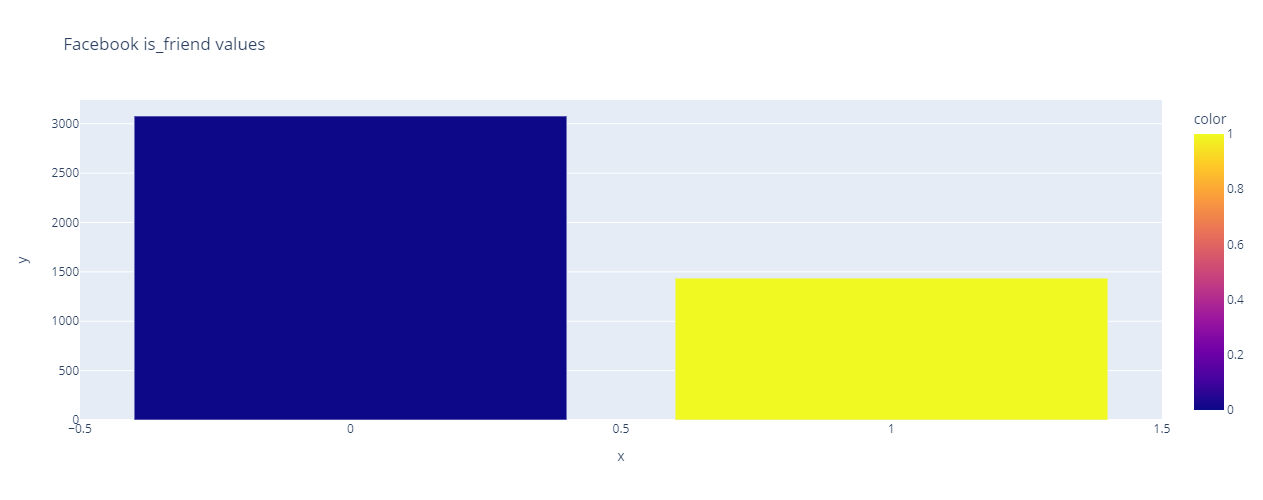

In [58]:
count = facebook_pairs.is_friend.value_counts()
print(count)

fig = px.bar(x=facebook_pairs.is_friend.unique(), y=count, color=facebook_pairs.is_friend.unique(),
             labels={"sex": "Gender", "smoker": "Smokes"}, 
             title="Facebook is_friend values") 
fig.update_layout(
    autosize=False,
    width=700,
    height=500,
)
fig.show()

[datetime.time(7, 0)]
              Time  Student1  Student2 Student1Class Student2Class
0       1385982020       454       640            MP            MP
1       1385982020         1       939         2BIO3         2BIO3
2       1385982020       185       258           PC*           PC*
3       1385982020        55       170         2BIO3         2BIO3
4       1385982020         9       453            PC            PC
...            ...       ...       ...           ...           ...
188503  1386345560       120       285            PC            PC
188504  1386345580        61       160         2BIO2         2BIO2
188505  1386345580       272       939         2BIO3         2BIO3
188506  1386345580       311       496            PC            PC
188507  1386345580       120       285            PC            PC

[188508 rows x 5 columns]


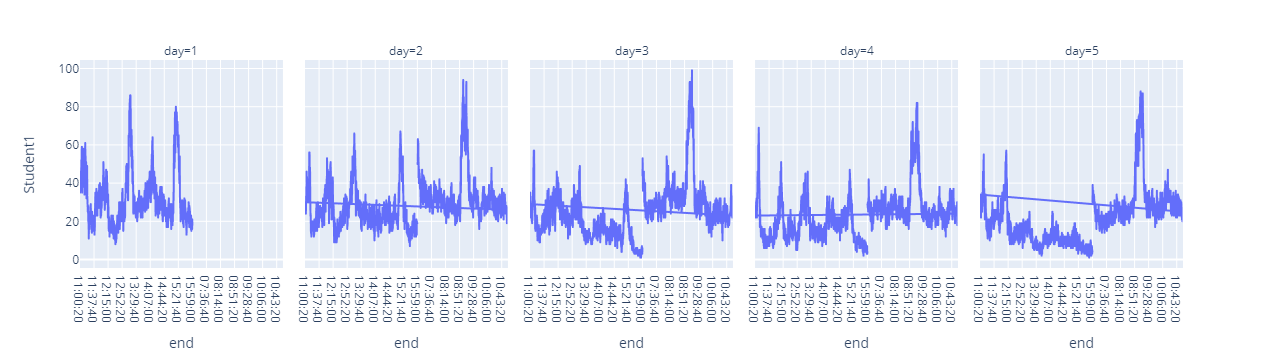

In [18]:
from datetime import datetime, timedelta
timed = timed_contacts.copy() 
timed = timed.sort_values(['Time'])
timed["start"] = pd.to_datetime(timed.Time, utc=True, unit='s') - timedelta(seconds=20)
timed["end"] = pd.to_datetime(timed.Time, utc=True, unit='s')

#timed["end_string"] = [datetime.strptime(i, "%H:%M:%S") for i in timed.end]

print(pd.to_datetime(['7:00:00']).time)
data = timed.groupby('end')['Student1'].count().reset_index()

data["day"] = data.end.dt.day - 1

data["end"] = pd.to_datetime(data["end"])

data["end"] = data.end.dt.strftime('%H:%M:%S')

data = data.sort_values(by=['day','end'])
print(timed_contacts)
#data = data.set_index(pd.DatetimeIndex(data['end']))

fig = px.line(data, x="end", y="Student1", facet_col="day")
fig.show()

The time series data of the contact times have some seasonality. The 5 days the data was recorded are clearly seen. Peaks are probably the breaks between classes where students are free to talk to other students. I assume the peaks are weaker later during the recording because students might be less active during the later stages of the day due to exhaustion. There might as well be more classes during the morning. 

In the following script all timed contacts are grouped together for each day and the weight from the variables student1 to student2 are added up to match the weight from 1-4 in the contact diaries. The last part creates a list of networks where each index represents one whole day as a nx network.

In [19]:
#print(timed.columns)
#grouped_time = timed.groupby(["end", "Student1", "Student2", "Student1Class", "Student2Class"]).count().reset_index()
grouped_time = timed.copy()
grouped_time["w"] = 20
dates = grouped_time.end.dt.floor('D')
grouped_time = grouped_time.groupby([dates, "Student1", "Student2", "Student1Class", "Student2Class"]).sum().reset_index().drop("Time", axis=1)

def binner(w):
    if w <= 300:
        return 1
    elif w <= 900:
        return 2
    elif w <= 3600:
        return 3
    else:
        return 4
    
def return_color(s):
    if s == "MP":
        return "skyblue"
    elif s == "MP*1":
        return "blue"
    elif s == "MP*2":
        return "darkblue"
    elif s == "PSI*":
        return "orchid"
    elif s == "PC":
        return "magenta"
    elif s == "PC*":
        return "grey"
    elif s == "2BIO1":
        return "lime"
    elif s == "2BIO2":
        return "green"
    elif s == "2BIO3":
        return "darkgreen"
    elif s == "M":
        return "skyblue"
    elif s == "F":
        return "magenta"
    elif s == "Unknown":
        return "black"

grouped_time['BinnedW'] = [binner(i) for i in grouped_time.w]

days = []

for day in grouped_time.end.unique():
    days.append(grouped_time[grouped_time.end == day])
    
#------------------------------------------------------------------

G_sensor_per_day = []

for entry in days:
    G_sensor = nx.Graph()
    nodes = list(G_sensor.nodes())
    
    for i in range(len(entry)):
        #print(entry)
        row = entry.iloc[i]
        student_meta = metadata[metadata.StudentID == row.Student1]
        G_sensor.add_node(row.Student1, Gender=student_meta.Gender, Class=student_meta.ClassID) 
        G_sensor.add_edge(row.Student1, row.Student2, weight=row.BinnedW)

    for (nodeID, members) in G_sensor.nodes().items():
        i = i + 1

        #add weights if not instantiated correctly
        if(members == {}):
            G_sensor.nodes[nodeID]["Class"] = metadata[metadata.StudentID == nodeID].ClassID.item()
            G_sensor.nodes[nodeID]["Gender"] = metadata[metadata.StudentID == nodeID].Gender.item()    
    

    #G_sensor.nodes(data=True)
    G_sensor_per_day.append(G_sensor)

print(len(G_sensor_per_day), " days")
print("Index 3 is the 5th of december where the contact diaries data set was created")

G_d = nx.DiGraph()

nodes = list(G_d.nodes())

for i in range(len(contact_diaries)):
    row = contact_diaries.loc[i,:]

    G_d.add_node(row.StudentID, Gender=row.Gender, Class=row.ClassID) 
    G_d.add_edge(row.StudentID, row.ReportedStudentID, weight=row.w)

G_d.nodes(data=True)

#This one is not mapped correctly
G_d.nodes[751]

5  days
Index 3 is the 5th of december where the contact diaries data set was created


{}

For the contact diaries, the merge function was enough to get information for plots.

In [20]:
pos = nx.drawing.layout.spring_layout(G_d, weight = 'Class', seed = 42)

i = 0;
for (nodeID, members) in G_d.nodes().items():
    i = i + 1
    
    #add weights if not instantiated correctly
    if(members == {}):
        G_d.nodes[nodeID]["Class"] = metadata[metadata.StudentID == nodeID].ClassID.item()
        G_d.nodes[nodeID]["Gender"] = metadata[metadata.StudentID == nodeID].Gender.item()    
        
    #nx.draw_networkx_nodes(G_d, pos, label=members["Class"] if i < 10 else "")                                                                                                        

#nx.draw_networkx_edges(G_d, pos)

#set title, legend and show plot
#plt.title('Classes', fontdict={'fontsize': 25})
#plt.legend()
#plt.axis('off')
#plt.show()

In [21]:
for e in G_d.edges():
    print("Sample weight: ", G_d[e[0]][e[1]])
    break

print("info: ", nx.info(G_d))

Sample weight:  {'weight': 2}
info:  DiGraph with 120 nodes and 502 edges


As shown above, the data set contains 120 nodes, 502 edges and 4.1833 average in/out degree.

### Trying to draw the different classes

In [63]:
#nx.draw_networkx(G_d, with_labels=False, node_color = colors, label=labels)
#set title, legend and show plot
#plt.title('Different Classes', fontdict={'fontsize': 25})
#plt.legend() #too many labels 
#plt.axis('off')
#plt.show()

This didn't work as the class labels were printed out multiple time in the matplot legend so I copied the approach of the course material.

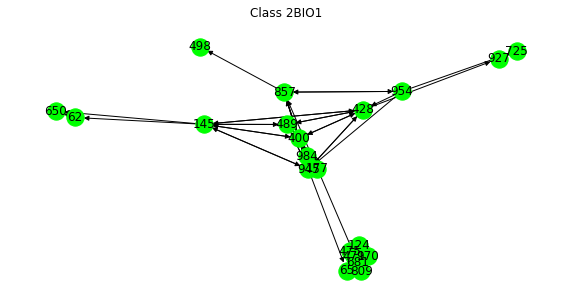

In [22]:
from collections import defaultdict
people_per_class_contact = defaultdict(list)
people_per_gender_contact = defaultdict(list)
for (id, attributes) in list(G_d.nodes().data()):
    people_per_class_contact[attributes["Class"]].append(id)
    people_per_gender_contact[attributes["Gender"]].append(id)
    
#print(attributes["Class"])
    
from collections import defaultdict
people_per_class_sensors = defaultdict(list)
people_per_gender_sensors = defaultdict(list)
for (id, attributes) in list(G_sensor_per_day[3].nodes().data()):
    if isinstance(attributes["Class"], str):
        people_per_class_sensors[attributes["Class"]].append(id)
    else:
        people_per_class_sensors[attributes["Class"].values[0]].append(id)
    
    if isinstance(attributes["Gender"], str):
        people_per_gender_sensors[attributes["Gender"]].append(id)
    else:
        people_per_gender_sensors[attributes["Gender"].values[0]].append(id)

#------------------------------------------------------------------------------------------

people_from_2Bio2 = {k: v for (k,v) in list(people_per_class_contact.items()) if "2BIO1" in k}

people_from_2Bio2_ids = set()
for (k, v) in people_from_2Bio2.items():
    people_from_2Bio2_ids.update(v)

G_2Bio2 = nx.subgraph(G_d, people_from_2Bio2_ids)

plt.figure(figsize=(10,5))
ax = plt.gca()
ax.set_title('Class 2BIO1')
G = nx.fast_gnp_random_graph(10,0.2)
nx.draw(G_2Bio2,with_labels=True, node_color=return_color("2BIO1"), ax=ax)
_ = ax.axis('off')

The reports contain information about 14 individuals from class 2BIO2. This bidrectional graph shows the data we're dealing with for the contact diaries. The student with ID 165 had the least contact with other students, while those in the middle of the graph were more connected. Calculating the exact connectivity using formulas would substantiate these findings even more. 

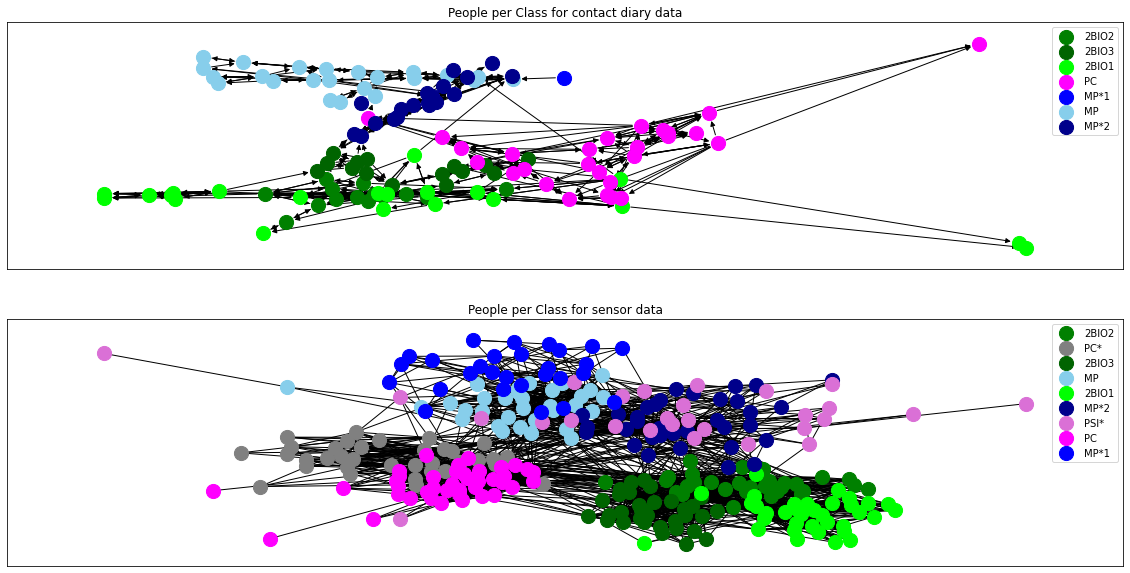

In [22]:
pos = nx.drawing.layout.spring_layout(G_d, weight = 'w', seed=41)

fig, ax = plt.subplots(2)
for (schoolclass, members) in people_per_class_contact.items():
    node_color = return_color(schoolclass)
    nx.draw_networkx_nodes(G_d, pos, nodelist=members, node_color=node_color, label = schoolclass, node_size=200, ax=ax[0])
nx.draw_networkx_edges(G_d, pos, ax=ax[0])                                                                                                        
ax[0].legend()
ax[0].set_title("People per Class for contact diary data")

pos = nx.drawing.layout.spring_layout(G_sensor_per_day[3], weight = 'BinnedW', seed=41)

for (schoolclass, members) in people_per_class_sensors.items():
    node_color = return_color(schoolclass)
    nx.draw_networkx_nodes(G_sensor_per_day[3], pos, nodelist=members, node_color=node_color, label = schoolclass, node_size=200, ax=ax[1])
nx.draw_networkx_edges(G_sensor_per_day[3], pos, ax=ax[1])                                                                                                        
ax[1].legend()
ax[1].set_title("People per Class for sensor data")

#set title, legend and show plot
plt.show()

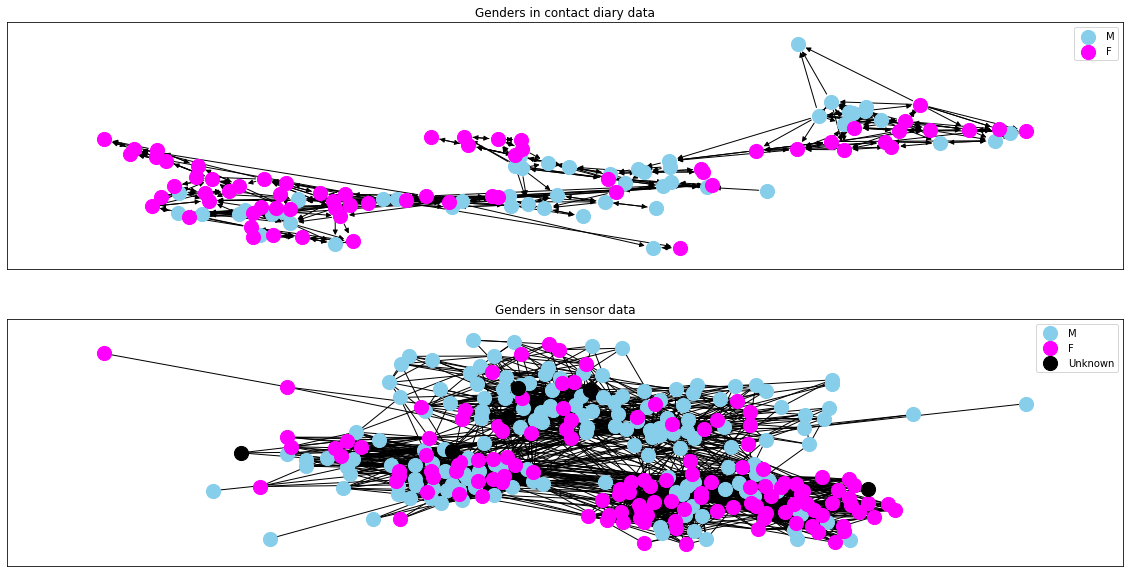

In [23]:
pos = nx.drawing.layout.spring_layout(G_d, weight = 'w')

fig, ax = plt.subplots(2)
for (genders, members) in people_per_gender_contact.items():
    node_color = return_color(genders)
    nx.draw_networkx_nodes(G_d, pos, nodelist=members, node_color=node_color, label = genders, node_size=200, ax=ax[0])
nx.draw_networkx_edges(G_d, pos, ax=ax[0])                                                                                                        
ax[0].legend()
ax[0].set_title("Genders in contact diary data")

pos = nx.drawing.layout.spring_layout(G_sensor_per_day[3], weight = 'BinnedW', seed=41)

for (genders, members) in people_per_gender_sensors.items():
    node_color = return_color(genders)
    nx.draw_networkx_nodes(G_sensor_per_day[3], pos, nodelist=members, node_color=node_color, label = genders, node_size=200, ax=ax[1])
nx.draw_networkx_edges(G_sensor_per_day[3], pos, ax=ax[1])                                                                                                        
ax[1].legend()
ax[1].set_title("Genders in sensor data")

plt.show()

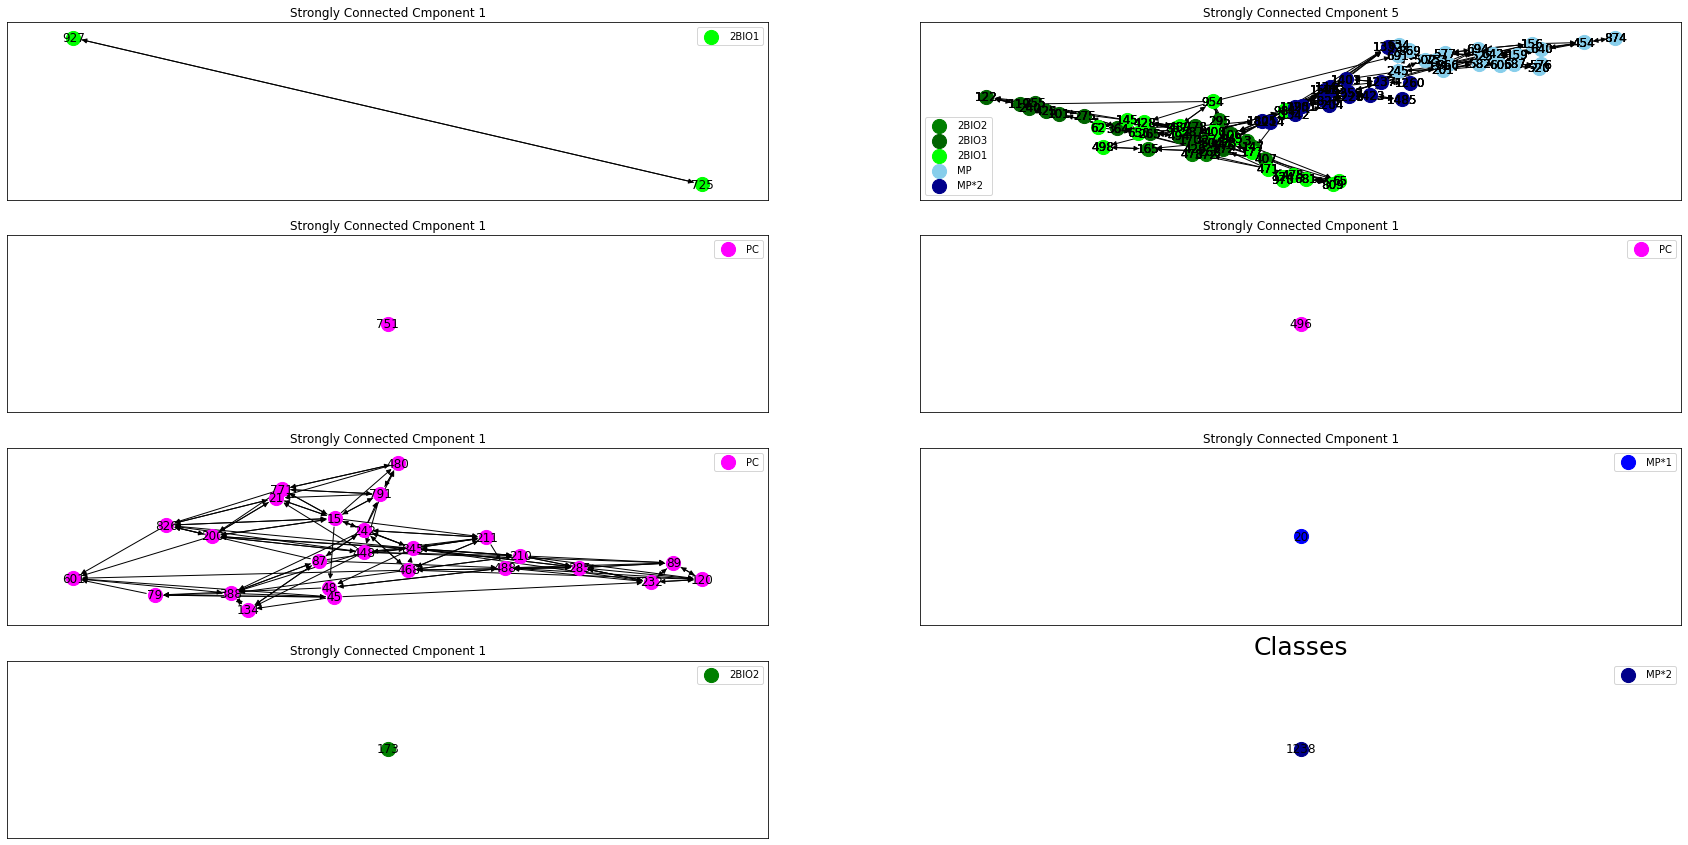

In [22]:
from src.graphutil.visualization import draw_graph_and_color_groups
from math import ceil
from itertools import zip_longest
strongly_connected_components = list(nx.strongly_connected_components(G_d))
#print(strongly_connected_components)

n_cols = 2

fig, axes = plt.subplots(nrows=int(ceil(len(strongly_connected_components)/n_cols)), 
                         ncols=n_cols, 
                         figsize=(30, 15))
pos = nx.drawing.layout.spring_layout(G_d, weight = 'w')

for comp, ax in zip(strongly_connected_components, axes.reshape(-1)):
    G_sub = G_d.subgraph(comp)
    people_per_class = defaultdict(list)
    for (id, attributes) in list(G_sub.nodes().data()):
        people_per_class[attributes["Class"]].append(id)
    
    i=0
    pos = nx.drawing.layout.spring_layout(G_sub, weight = 'w')
    for (schoolclass, members) in people_per_class.items():
        node_color = return_color(schoolclass)
        i = i + 1
        nx.draw_networkx_nodes(G_sub, pos, nodelist=members, node_color=node_color, label = schoolclass, ax=ax, node_size=200)
        nx.draw_networkx_labels(G_sub,pos, ax=ax)
    nx.draw_networkx_edges(G_sub, pos, ax=ax)
    ax.legend()
    ax.set_title("Strongly Connected Cmponent " + str(i))
plt.title('Classes', fontdict={'fontsize': 25})
plt.legend()
plt.axis('off')
plt.show()

These are the strongly connected components in the diary network. A strongly connected component is a where every node is conencted to every other node if we follow the directions of the edges. The plots show that class PC makes one strongly connected component by itself. Some students are alone in their own strongly connected component. They reported contact with other students but other students didn't report contact with them. Maybe other students forgot to report them.

In [23]:
G_undirected = G_d.to_undirected()
weakly_connected_components = nx.connected_components(G_undirected)

weakly_connected_components = nx.connected_components(G_sensor_per_day[3])

There is just one weakly connected component for the whole graph for both networks.

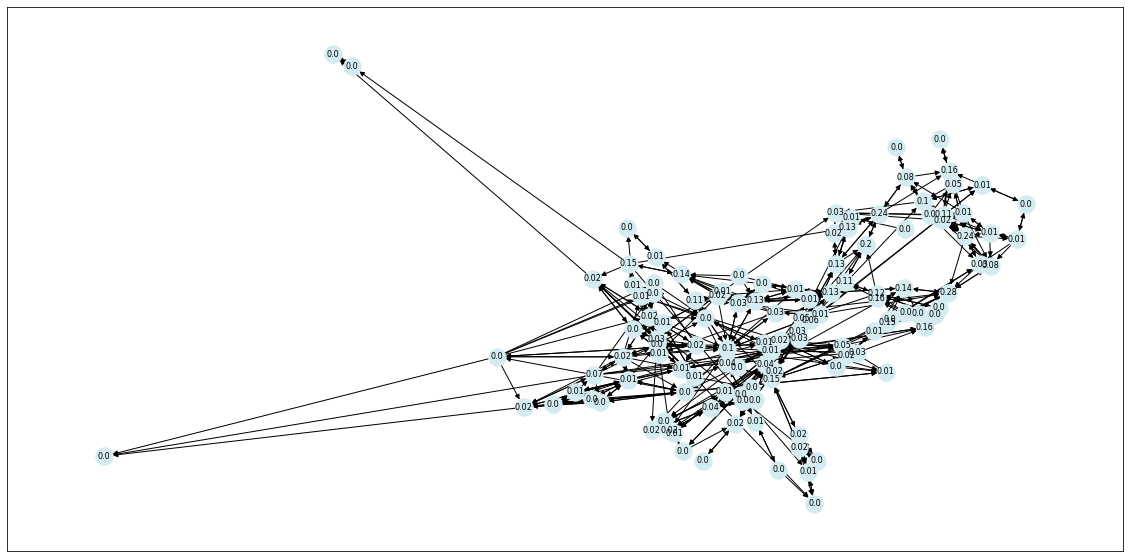

In [24]:
centralities = dict()
#centralities['eigenvector'] = nx.eigenvector_centrality(G_d)
centralities['degree'] = nx.degree_centrality(G_d)
centralities['betweenness'] = nx.betweenness_centrality(G_d)
centralities['closeness'] = nx.closeness_centrality(G_d)
#print(centralities['degree'])
nx.set_node_attributes(G_d, [], "betweenness")

for (nodeID, members) in G_d.nodes().items():
    #node_color = len(members) * [random_color[i]]
    i = i + 1
    G_d.nodes[nodeID]["betweenness"] = round(centralities['betweenness'][nodeID] * 100) / 100
        
pos = nx.drawing.layout.spring_layout(G_d, weight = 'w')

node_labels = nx.get_node_attributes(G_d,'betweenness')
#nx.draw_networkx_edges(G_d, pos)
nx.draw_networkx(G_d, pos, with_labels=True, labels=node_labels, cmap="Heat", node_color="#d4ebf2", font_size=8)

In [25]:
G_sensor_cleaned = G_sensor_per_day[3].copy()
G_diaries_cleaned = G_d.copy()

for (id, attributes) in list(G_sensor_cleaned.nodes().data()):
    if G_d.has_node(id) == False:
        G_sensor_cleaned.remove_node(id)
        
for (id, attributes) in list(G_diaries_cleaned.nodes().data()):
    if G_sensor_cleaned.has_node(id) == False:
        G_diaries_cleaned.remove_node(id)
        
print("G_sensor_cleaned: ", nx.info(G_sensor_cleaned))
print("G_diaries_cleaned: ", nx.info(G_diaries_cleaned))

G_sensor_cleaned:  Graph with 109 nodes and 488 edges
G_diaries_cleaned:  DiGraph with 109 nodes and 416 edges


sample: 
[[0. 1. 4. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [4. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Correlation matrix of the reported weights between the students:  [[1.         0.84357949]
 [0.84357949 1.        ]]


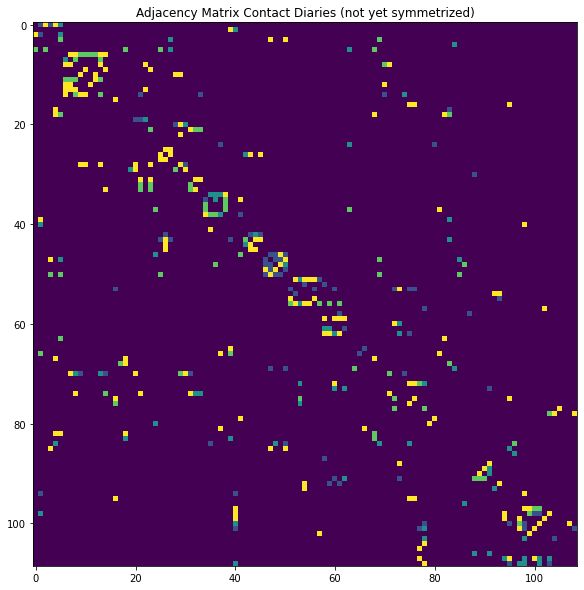

In [26]:
nodes = list(G_diaries_cleaned.nodes())
G_d_symmetric_np = nx.to_numpy_array(G_diaries_cleaned, nodes)
print("sample: ")
print(G_d_symmetric_np[:, :])
plt.imshow(G_d_symmetric_np[:, :], interpolation='nearest')

x = np.array([])
y = np.array([])
for i in range(G_d_symmetric_np.shape[0]):
    for j in range(G_d_symmetric_np.shape[0]):
        
        x= np.append(x, G_d_symmetric_np[i,j])
        y= np.append(y, G_d_symmetric_np[j,i]) 
        
        if (G_d_symmetric_np[i,j] != G_d_symmetric_np[j,i]):
            maxi = np.maximum(G_d_symmetric_np[i,j], G_d_symmetric_np[j,i]) 
            G_d_symmetric_np[i,j] = maxi
            G_d_symmetric_np[j,i] = maxi   
            
R2 = np.corrcoef(x, y)

print("Correlation matrix of the reported weights between the students: ", R2) 
plt.title("Adjacency Matrix Contact Diaries (not yet symmetrized)")
plt.show()

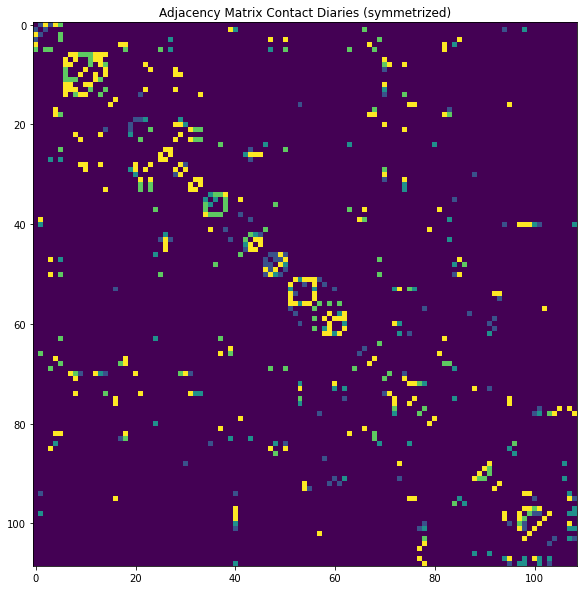

In [27]:
plt.imshow(G_d_symmetric_np[:, :], interpolation='nearest')
plt.title("Adjacency Matrix Contact Diaries (symmetrized)")
plt.show()

This is the symmetric network based on the contact diaries. In the paper it is shown that using the higher value of unsymmetric values yields a network that is closer to the sensor data network than using the lower value of unsymmetric values. The matrix can be compared now to a matrix of the sensor data (which is automatially symmetric) to find out how they differ and to further define some statistical metrics like: "Is the difference between reported contact time and sensor based contact time significant?" 

sample: 
[[0. 1. 1. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 1. 0. 1.]
 [0. 0. 0. ... 0. 1. 0.]]
Correlation matrix of the reported weights between the students:  [[1. 1.]
 [1. 1.]]


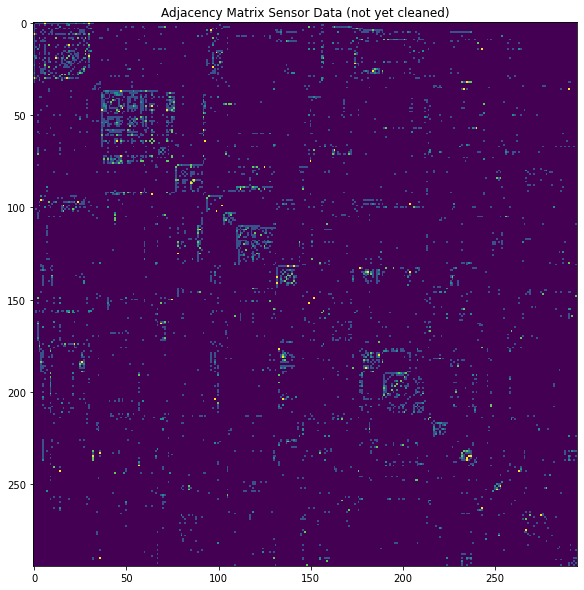

In [28]:
nodes = list(G_sensor_per_day[3].nodes())
G_sensor_matrix = nx.to_numpy_array(G_sensor_per_day[3], nodes)
print("sample: ")
print(G_sensor_matrix[:, :])
plt.imshow(G_sensor_matrix[:, :], interpolation='nearest')

x = np.array([])
y = np.array([])
for i in range(G_sensor_matrix.shape[0]):
    for j in range(G_sensor_matrix.shape[0]):
        
        x= np.append(x, G_sensor_matrix[i,j])
        y= np.append(y, G_sensor_matrix[j,i]) 
        
        if (G_sensor_matrix[i,j] != G_sensor_matrix[j,i]):
            print(G_sensor_matrix[i,j], G_sensor_matrix[j,i])
            #maxi = np.maximum(G_sensor_matrix[i,j], G_sensor_matrix[j,i]) 
            #G_sensor_matrix[i,j] = maxi
            #G_sensor_matrix[j,i] = maxi   
            
R2 = np.corrcoef(x, y)

print("Correlation matrix of the reported weights between the students: ", R2) 
plt.title("Adjacency Matrix Sensor Data (not yet cleaned)")
plt.show()

sample: 
[[0. 1. 4. ... 0. 0. 0.]
 [1. 0. 1. ... 0. 0. 0.]
 [4. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 1.]
 [0. 0. 0. ... 1. 0. 1.]
 [0. 0. 0. ... 1. 1. 0.]]
Correlation matrix of the reported weights between the students:  [[1. 1.]
 [1. 1.]]


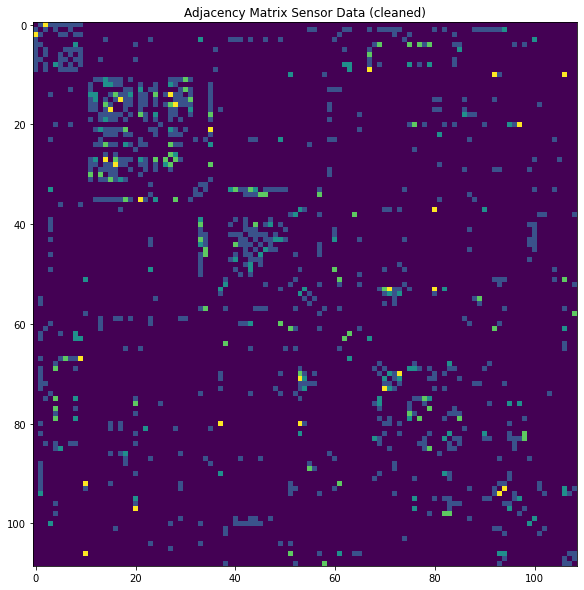

In [29]:
nodes = list(G_sensor_cleaned.nodes())
G_sensor_matrix = nx.to_numpy_array(G_sensor_cleaned, nodes)
print("sample: ")
print(G_sensor_matrix[:, :])
plt.imshow(G_sensor_matrix[:, :], interpolation='nearest')

x = np.array([])
y = np.array([])
for i in range(G_sensor_matrix.shape[0]):
    for j in range(G_sensor_matrix.shape[0]):
        
        x= np.append(x, G_sensor_matrix[i,j])
        y= np.append(y, G_sensor_matrix[j,i]) 
        
        if (G_sensor_matrix[i,j] != G_sensor_matrix[j,i]):
            print(G_sensor_matrix[i,j], G_sensor_matrix[j,i])
            #maxi = np.maximum(G_sensor_matrix[i,j], G_sensor_matrix[j,i]) 
            #G_sensor_matrix[i,j] = maxi
            #G_sensor_matrix[j,i] = maxi   
            
R2 = np.corrcoef(x, y)

print("Correlation matrix of the reported weights between the students: ", R2) 
plt.title("Adjacency Matrix Sensor Data (cleaned)")
plt.show()

### Compare datasets

In the adjacency matrices it's already apparent that people overestimate the time they spent together with other people in the reported diaries. This is actually also noted in the research paper. This is because people tend to perceive the time spent in some activities differently from the reality. Also, there is much more data in the sensor data for the same amount of edges. This is because sensors pick up small interactions which student forget to mention in their diaries. This means the network is more interconnected and yields higher centrality scores.

In [30]:
Cd_sensor = nx.degree_centrality(G_sensor_cleaned)

G_sensor_cleaned_nodes = list(G_sensor_cleaned.nodes())
G_sensor_cleaned_nodes.sort()
G_diaries_cleaned_nodes = list(G_diaries_cleaned.nodes())
G_diaries_cleaned_nodes.sort()

Cd_sensor_array = np.array([])

for node in G_sensor_cleaned_nodes:
    Cd_sensor_array = np.append(Cd_sensor_array, Cd_sensor[node])
    
degree_centrality_sensor = np.sum(max(Cd_sensor_array)-Cd_sensor_array) / ((Cd_sensor_array.shape[0] - 1)*(Cd_sensor_array.shape[0] - 2))
    
print("Degree centrality of sensor data: ", degree_centrality_sensor)
    
Cd_diary = nx.degree_centrality(G_diaries_cleaned)

Cd_diary_array = np.array([])

for node in G_diaries_cleaned_nodes:
    Cd_diary_array = np.append(Cd_diary_array, Cd_diary[node])
    
degree_centrality_diary = np.sum(max(Cd_diary_array)-Cd_diary_array) / ((Cd_diary_array.shape[0] - 1)*(Cd_diary_array.shape[0] - 2))

print("Degree centrality of diaries: ", degree_centrality_diary)

print(x == y)

Degree centrality of sensor data:  0.0012267156391420843
Degree centrality of diaries:  0.0008180775098393649
[ True  True  True ...  True  True  True]


In [31]:
print(f"Density of sensor data (cleaned): {nx.density(G_sensor_cleaned)}")
print(f"Density of contact diaries data (cleaned): {nx.density(G_diaries_cleaned)}")

Density of sensor data (cleaned): 0.08290859667006456
Density of contact diaries data (cleaned): 0.03533809038396194


The graph density of the sensor data is obviously much higher than the graph density of the contact diaries network. This means density of contacts and also the speed information is spread might be underestimated by contact diaries. If we replace "information" by "diseases" this could mean that diseases spread faster than anyone could expect solely off of contact diaries. Both networks are not very dense though.  

### Intermatrix correlation

In [43]:
print(G_sensor_matrix.shape)
print(G_d_symmetric_np.shape)

qap = utils.qap.QAP(G_sensor_matrix, G_d_symmetric_np, 200)
qap.qap()

(109, 109)
(109, 109)
Pearson Correlation:  0.04457007828091187
p-value:  1.313551108879351e-06
Pearson's correlation:
  [[1.         0.04457008]
 [0.04457008 1.        ]]
Z-Test:  (4.036357428865388, 5.4287490057342387e-05)
T-Test:  Ttest_indResult(statistic=4.036357428865388, pvalue=5.445910858140558e-05)


The T-Test shows that the correlation between the two matrices is significant.

### Has a person with a lot of facebook friends automatically a higher betweenness centrality?

Monadic hypothesis: People with a high facebook friend count (within the high school network) have a higher betweenness centrality.

H0: They dont have a higher betweenness centrality.

H1: They do have a higher betweenness centrality.

Siginificant value of p: below 0.05.

In [75]:
from scipy.stats import pearsonr

arr = np.array([])

betweenness_centrality = nx.betweenness_centrality(G_sensor_per_day[3])

facebook_pairs_count = facebook_pairs[facebook_pairs.is_friend == 1].groupby(["StudentID"]).count().reset_index()
#print(facebook_pairs_count[facebook_pairs_count.StudentID == node].is_friend.values[0])
for node in G_sensor_per_day[3]:
    
    if not facebook_pairs_count[facebook_pairs_count.StudentID == node].empty:
        arr = np.append(arr, [betweenness_centrality[node], facebook_pairs_count[facebook_pairs_count.StudentID == node].is_friend.values[0]])
    
arr = arr.reshape(-1, 2)

stat, p = pearsonr(arr[:,0], arr[:,1])
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Probably independent')
else:
    print('Probably dependent')

stat=0.233, p=0.007
Probably dependent


The Pearson correlation tests whether two variables are lienarly correlated. In this case we can reject the null-hypothesis and say that the facebook friend count within the network does linearly correlate with a higher betweenness centrality.

In [76]:
from scipy.stats import spearmanr

stat, p = spearmanr(arr[:,0], arr[:,1])
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
	print('Probably independent')
else:
	print('Probably dependent')

stat=0.184, p=0.034
Probably dependent


The Spearman correlation tests whether two random variables have a monotonic relationship. It is robust to outliers unlike Pearsons's correlation. The null-hypothesis can also be rejected using this approach.

### Link Prediciton

The adjacency matrix was symmetrized as described in the paper.

In [44]:
#nx.write_gexf(G_sensor_per_day[3], "./data/test.gexf")

In [46]:
from operator import itemgetter
def random_sample(graph, perc=0.15):
    num_removed_edges = int(perc * graph.number_of_edges())
    edge_subset = random.sample(graph.edges(), num_removed_edges)
    # Remove some edges
    sample = graph.copy()
    sample.remove_edges_from(edge_subset)
    return sample, edge_subset

def accuracy(original_graph, predicted_edges, removed_edges):
    sorted_pred = sorted(predicted_edges,key=itemgetter(2), reverse=True)
    top_predictions = sorted_pred[:len(removed_edges)]
    correctly_predicted = [((u,v) in removed_edges) for (u,v,s) in top_predictions]
    accuracy = (sum(correctly_predicted)) / len(correctly_predicted)
    return accuracy

def calculate_communities(graph):
    import community
    partition = community.best_partition(graph)
    ## Plot graph (Uncomment for plotting graph with communities)
    #print(partition.values())
    #pos = nx.spring_layout(graph)
    #plt.figure(figsize=(12,8))
    #nx.draw_networkx_nodes(graph, pos, node_size=600, cmap=plt.cm.RdYlBu, node_color=list(partition.values()))
    #nx.draw_networkx_edges(graph, pos, alpha=0.3)
    #plt.show(graph)
    
    ## Set community attribute on nodes
    for node, community in partition.items():
        graph.nodes[node]['community'] = community
        
adamic = "Adamic Adar"
jaccard = "Jaccard"
resource_alloc = "Resource Allocation"
pref_attachment = "Preferential Attachment"
cn_soundarajan = "CN Soundarajan Hopcroft"
ra_index_soudarajan = "RA Index Soudarjan"
within_inter_cluster = "Within Inter Cluster"

prediction_accuracies = defaultdict(list)

print("Start sampling")
for i in range(0, 50):
    if i % 5 == 0:
        print(f"\tIteration: {i}")
    sample_graph, removed_edges = random_sample(G_sensor_per_day[3])
    calculate_communities(sample_graph)
    prediction_accuracies[adamic].append(accuracy(G_sensor_per_day[3], list(nx.adamic_adar_index(sample_graph)), removed_edges))
    prediction_accuracies[jaccard].append(accuracy(G_sensor_per_day[3], list(nx.jaccard_coefficient(sample_graph)), removed_edges))
    prediction_accuracies[resource_alloc].append(accuracy(G_sensor_per_day[3], list(nx.resource_allocation_index(sample_graph)), removed_edges))
    prediction_accuracies[cn_soundarajan].append(accuracy(G_sensor_per_day[3], list(nx.cn_soundarajan_hopcroft(sample_graph)), removed_edges))
    prediction_accuracies[ra_index_soudarajan].append(accuracy(G_sensor_per_day[3], list(nx.ra_index_soundarajan_hopcroft(sample_graph)), removed_edges))
    prediction_accuracies[within_inter_cluster].append(accuracy(G_sensor_per_day[3], list(nx.within_inter_cluster(sample_graph)), removed_edges))                       
    prediction_accuracies[pref_attachment].append(accuracy(G_sensor_per_day[3], list(nx.preferential_attachment(sample_graph)), removed_edges))

print("Finished Sampling")

Start sampling
	Iteration: 0


C:\Users\bruno\AppData\Local\Temp/ipykernel_21204/1280185013.py:4: DeprecationWarning:

Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.



	Iteration: 5
	Iteration: 10
	Iteration: 15
	Iteration: 20
	Iteration: 25
	Iteration: 30
	Iteration: 35
	Iteration: 40
	Iteration: 45
Finished Sampling


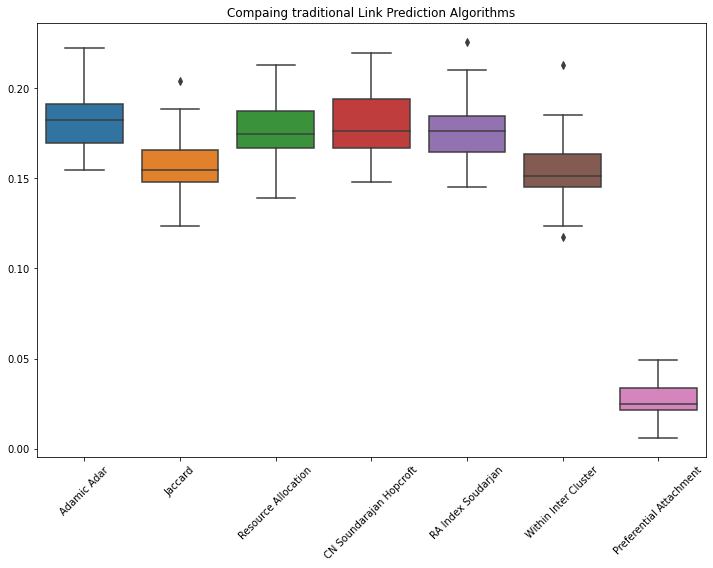

In [49]:
plt.figure(figsize=(12,8))
chart = sns.boxplot(data=pd.DataFrame.from_dict(prediction_accuracies), orient='v')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.title("Compaing traditional Link Prediction Algorithms")
plt.show()

The link predictions copied from the exercises show low accuracy. The best accuracies are achieved by the algorithms Adamic Adar and Soundarajan Hopcroft

GCNs (Graph Convolutional Networks) are convolutional networks similar to CNNs but for graphs. They use convolution on certain parts of the graph to find underlying patterns. I tried implementing one to compare with the link prediction methods copied from the exercises. 

Links:

https://theaisummer.com/gnn-architectures/

https://muhanzhang.github.io/papers/KDD_2017.pdf

https://github.com/imayachita/Explore_GCN/blob/master/Building_GCN.ipynb

In [79]:
import torch
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
import torch.nn.functional as F
from torch_geometric.utils.convert import from_networkx

class GCNConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(GCNConv, self).__init__(aggr='add')
        self.lin = torch.nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        # Step 1: Add self-loops
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # Step 2: Multiply with weights
        x = self.lin(x)

        # Step 3: Calculate the normalization
        row, col = edge_index
        deg = degree(row, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        # Step 4: Propagate the embeddings to the next layer
        return self.propagate(edge_index, size=(x.size(0), x.size(0)), x=x,
                              norm=norm)

    def message(self, x_j, norm):
        # Normalize node features.
        return norm.view(-1, 1) * x_j
    

class Net(torch.nn.Module):
    def __init__(self, dataset):
        super(Net, self).__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)
    
def train(data, labels, plot=False):
    train_accuracies, test_accuracies = list(), list()
    for epoch in range(100):
            model.train()
            optimizer.zero_grad()
            out = model(data)
            loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
            loss.backward()
            optimizer.step()

            train_acc = test(data)
            test_acc = test(data, train=False)

            train_accuracies.append(train_acc)
            test_accuracies.append(test_acc)
            print('Epoch: {:03d}, Loss: {:.5f}, Train Acc: {:.5f}, Test Acc: {:.5f}'.
                  format(epoch, loss, train_acc, test_acc))

In [81]:
#Get the Adjacency Matrix (A) and Node Features Matrix (X) as numpy array

print(list(G_sensor_per_day[3].nodes()))
A = np.array(nx.attr_matrix(G_sensor_per_day[3], node_attr='BinnedW')[0])
X = np.array(nx.attr_matrix(G_sensor_per_day[3], node_attr='BinnedW')[1])
X = np.expand_dims(X,axis=1)

print('Shape of A: ', A.shape)
print('\nShape of X: ', X.shape)
print('\nAdjacency Matrix (A):\n', A)
print('\nNode Features Matrix (X):\n', X)


#for i in range(0, 50):
 #   sample_graph, removed_edges = random_sample(G_sensor_per_day[3])
 #   y_graph = from_networkx(G_sensor_per_day[3])
  #  dataset = Planetoid(root='/tmp/Cora', name='Cora')
    
   # plot_dataset(dataset)

    #device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    #model = Net(dataset).to(device)
    #data = dataset[0].to(device)
    #optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

    #train(x_graph, y_graph, , plot=True)

[3, 46, 58, 61, 63, 106, 147, 156, 160, 177, 196, 213, 226, 257, 267, 295, 312, 327, 339, 353, 372, 407, 441, 477, 544, 545, 626, 653, 763, 836, 884, 979, 1512, 4, 424, 797, 1201, 9, 15, 21, 45, 71, 80, 172, 194, 200, 211, 232, 242, 253, 254, 285, 311, 322, 413, 448, 453, 471, 488, 496, 525, 601, 681, 751, 826, 998, 1320, 1518, 14, 181, 256, 356, 89, 134, 210, 492, 845, 20, 41, 277, 290, 376, 387, 438, 497, 513, 638, 655, 702, 866, 869, 958, 120, 706, 27, 173, 179, 184, 275, 612, 674, 720, 886, 32, 131, 176, 227, 440, 920, 1423, 34, 38, 54, 151, 159, 201, 220, 236, 502, 605, 642, 658, 691, 243, 564, 634, 640, 687, 694, 753, 1359, 1412, 39, 111, 117, 122, 240, 252, 265, 364, 447, 871, 883, 959, 219, 391, 1332, 1543, 1828, 335, 388, 582, 765, 882, 977, 1204, 268, 504, 1218, 1237, 1238, 1260, 85, 115, 116, 190, 209, 269, 450, 548, 615, 867, 938, 346, 429, 464, 784, 927, 984, 70, 101, 119, 125, 132, 199, 202, 272, 425, 576, 649, 65, 124, 400, 443, 465, 487, 527, 531, 809, 854, 859, 945, 99

KeyError: 'BinnedW'

### Conclusion:

Merging several different social network data sets together took a lot of time even though the data sets were already pretty clean. Working with networkx was pretty difficult and I think gephi would have been easier to draw the graphes. They don't look particularly good in python. Working alone was also difficult as I felt like with another person I could have had one or two brain storming sessions. In a group there could have been more creativity in the analysis. There are tons of metrics that can be analysed with the data presented here. There is potential to use the time series data to train a neural network to predict contacts based on additional time based attributes. I wish there was a way to know the times for breaks in this particular high school in France as this would improve prediction. In the end I could compare some basic metrics and also do a simple correlation test to statistically prove that people with a high number of facebook friends within the network are also pretty connected in the same network. 

I wanted to compare the matrices of the contact diaries data and the sensor data. Which obviously showed high correlation. I had to download the QAP package from github.

For link prediction I wanted to see whether neural networks had the potential for better link prediction than the traditional algorithms but I had difficulties understanding the idea behind it. The algorithm's accuracies are based on the parameters "original graph", "sample graph" and "removed nodes". When looking at code samples from the internet after googling "link prediction using neural networks", I wasn't sure if they used the same approach with neural networks.

ResNet identity mapping because most of the networks in training dont produce labels, that look very different from the input. (original vs sample graph in the Übungen)

Related works for later read: 

https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&ved=2ahUKEwi11p2d3Mb1AhXlh_0HHWqDA-AQFnoECAwQAQ&url=https%3A%2F%2Fwww.mdpi.com%2F2078-2489%2F10%2F5%2F172%2Fpdf&usg=AOvVaw2H5kx_1B7I8ObTQ7sSIPFr

https://scholar.uwindsor.ca/cgi/viewcontent.cgi?article=9313&context=etd

https://proceedings.neurips.cc/paper/2018/file/53f0d7c537d99b3824f0f99d62ea2428-Paper.pdf

https://ieeexplore.ieee.org/document/9207301